## Functions Needed For Branch And Bound
Run the next block once

In [146]:
import gurobipy as grb
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mincut import MinimumCut

def get_df(root,INPUT):
    filename = root+INPUT
    hd = pd.read_csv(filename, delimiter=' ',nrows = 0)

    c = 1
    colname = list(hd.columns)
    ncol = len(colname)
    while 'Unnamed' in colname[0]:
        hd = pd.read_csv(filename,delimiter=' ',nrows=0, usecols=np.arange(c,ncol))
        colname=list(hd.columns)
        c+=1

    n = int(colname[0])
    m = int(colname[1])

    df = pd.read_csv(filename,delimiter=' ', names=['End1','End2','Cost'], skiprows=1, index_col=False)

    return df,n,m

def initialize(df,n,m):
    c = np.array(df["Cost"])
    Model = grb.Model()
    x = Model.addVars(m,obj=c,lb=0.0,ub=1.0,vtype=GRB.CONTINUOUS, name='x')
    Model.modelSense = GRB.MINIMIZE

    #We can add the basic IO constraints true for EVERY branch
    #CONSTRAINTS
    #IO each node has exactly two arcs connected to it
    N1 = np.array(df["End1"])
    N2 = np.array(df["End2"])
    for i in range(n):
        ind_i1 = np.argwhere(N1 == i)
        ind_i1 = np.append(ind_i1, np.argwhere(N2 == i))
        Model.addConstr(grb.quicksum(x[e] for e in ind_i1) == 2)
    Model.update()
    lpname = INPUT.split('.')[0]+"_init.lp"
    Model.write(lpname)

    return Model,x


def solve_LP(df,n,m,Model,x):
    #print("THis is x in LP", len(x))
    Model.optimize()
    
    if Model.status == 2:
        x_lp = np.zeros((m,))
        for j in range(m):
            x_lp[j] = x[j].x
        
        min_lp = Model.objVal
        return x_lp, min_lp
    
    elif Model.status == 3:
        #Gurobi says LP is infeasible
        x_lp = np.zeros((m,))
        min_lp = np.inf
        return x_lp, min_lp
    
    else:
        print("In solve_LP")
        print("LP neither optimal nor infeasible")

        
def check_if_binary(x_lp):
    tol = 1e-9
    tmp = (np.abs(x_lp)>tol)&(np.abs(x_lp-1)>tol)
    is_binary = np.count_nonzero(tmp) == 0
    if is_binary:
        return -1
    else:
        nb_ind = np.argwhere(tmp)
        return np.squeeze(nb_ind[0])
    
    
def main_TSP(root,INPUT):
    df,n,m = get_df(root,INPUT)
    M0,x0 = initialize(df,n,m)
    best_cost = np.inf
    queque = []
    queque.append(M0)
    
    while len(queque) != 0:
        Model = queque.pop(0)
        x = Model.getVars()
        Model.Params.LogToConsole = 0
        x_lp, min_lp = solve_LP(df,n,m,Model,x)
        
        if sum(x_lp>1) or sum(x_lp<0):
            continue
        if min_lp >= best_cost or min_lp == np.inf:
            continue
        if check_if_binary(x_lp) == -1:
            #Then x_lp is binary
            x_star = x_lp
            best_cost = min_lp
            Model.write("bestmodel.lp")
        else:
            nb_ind = check_if_binary(x_lp)
            #now create two models with added constraint
            #x[nb_ind] == 0 and x[nb_ind] == 1
            
            M1 = Model.copy()
            x = M1.getVars()
            M1.addConstr(x[nb_ind] == 0)
            
            M2 = Model.copy()
            x = M2.getVars()
            M2.addConstr(x[nb_ind] == 1)
            M1.update()
            M2.update()
            queque.append(M1)
            queque.append(M2)
    print("best_cost = ", best_cost)
    return x_star, best_cost,df,n,m

def edges_to_nodes(e,df):
    return np.squeeze(np.array(df["End1"][e])), np.squeeze(np.array(df["End2"][e]))


import networkx as nx
def create_G_sol(x_star,df,n,m,INPUT):
    N1 = np.array(df["End1"])
    N2 = np.array(df["End2"])
    G = nx.Graph()
    #G.add_nodes_from(range(n))
    for i in range(m):
        if x_star[i] > 0:
            n1,n2 = edges_to_nodes(i,df)
            G.add_edge(int(n1),int(n2),weight=x_star[i])
            #notice x_star[i] should be 1
    nx.draw_shell(G)
    plt.title(INPUT)
    savefilename = "./Cities/" + INPUT.split('.')[0] + ".png"
    plt.savefig(savefilename)
    plt.title(INPUT)
    plt.show()

# HERE IS WHERE YOU INPUT YOUR DATASET AND RUN THE PROGRAM
root is directory where .txt files live

In [151]:
root = "./Cities/"
INPUT = "sh07.csv"

### Run this block to solve the "TSP"

In [152]:
x, val, df,n,m= main_TSP(root,INPUT)

best_cost =  106.4


### Run this block to visualize the solution

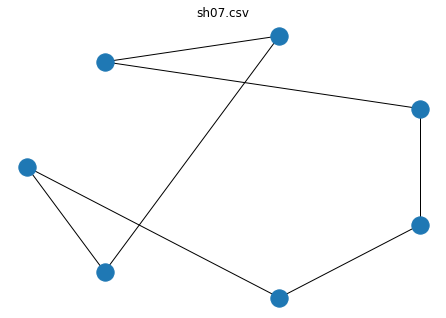

In [153]:
create_G_sol(x,df,n,m, INPUT)